# Mobile Customer Churn

In this Portfolio task you will work with some (fake but realistic) data on Mobile Customer Churn.  Churn is where
a customer leaves the mobile provider.   The goal is to build a simple predictive model to predict churn from available features. 

The data was generated (by Hume Winzar at Macquarie) based on a real dataset provided by Optus.  The data is simulated but the column headings are the same. (Note that I'm not sure if all of the real relationships in this data are preserved so you need to be cautious in interpreting the results of your analysis here).  

The data is provided in file `MobileCustomerChurn.csv` and column headings are defined in a file `MobileChurnDataDictionary.csv` (store these in the `files` folder in your project).

Your high level goal in this notebook is to try to build and evaluate a __predictive model for churn__ - predict the value of the CHURN_IND field in the data from some of the other fields.  Note that the three `RECON` fields should not be used as they indicate whether the customer reconnected after having churned. 

__Note:__ you are not being evaluated on the _accuracy_ of the model but on the _process_ that you use to generate it.  You can use a simple model such as Logistic Regression for this task or try one of the more advanced methods covered in recent weeks.  Explore the data, build a model using a selection of features and then do some work on finding out which features provide the most accurate results.  

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [34]:
churn = pd.read_csv("files/MobileCustomerChurn.csv", na_values=["NA", "#VALUE!"], index_col='INDEX')
churn.head()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,CFU,SERVICE_TENURE,PLAN_ACCESS_FEE,BYO_PLAN_STATUS,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,...,CONTRACT_STATUS,PREV_CONTRACT_DURATION,HANDSET_USED_BRAND,CHURN_IND,MONTHLY_SPEND,COUNTRY_METRO_REGION,STATE,RECON_SMS_NEXT_MTH,RECON_TELE_NEXT_MTH,RECON_EMAIL_NEXT_MTH
INDEX,,,,,,,,,,,,,,,,,,,,,
1,1,46,1,30.0,CONSUMER,46,54.54,NON BYO,15,0,...,OFF-CONTRACT,24,SAMSUNG,1,61.40,COUNTRY,WA,NaN,NaN,NaN
2,2,60,3,55.0,CONSUMER,59,54.54,NON BYO,5,0,...,OFF-CONTRACT,24,APPLE,1,54.54,METRO,NSW,NaN,NaN,NaN
3,5,65,1,29.0,CONSUMER,65,40.90,BYO,15,0,...,OFF-CONTRACT,12,APPLE,1,2.50,COUNTRY,WA,NaN,NaN,NaN
4,6,31,1,51.0,CONSUMER,31,31.81,NON BYO,31,0,...,OFF-CONTRACT,24,APPLE,1,6.48,COUNTRY,VIC,NaN,NaN,NaN
5,8,95,1,31.0,CONSUMER,95,54.54,NON BYO,0,0,...,OFF-CONTRACT,24,APPLE,1,100.22,METRO,NSW,NaN,NaN,NaN


## Data Cleaning an Summary:

In [35]:
# the number of row and column in the dataset
churn.shape

(46206, 21)

We check if the dataset has any missing values to deal with.

In [36]:
churn.isna().sum()

CUST_ID                             0
ACCOUNT_TENURE                      0
ACCT_CNT_SERVICES                   0
AGE                                76
CFU                                 0
SERVICE_TENURE                      0
PLAN_ACCESS_FEE                     0
BYO_PLAN_STATUS                     0
PLAN_TENURE                         0
MONTHS_OF_CONTRACT_REMAINING        0
LAST_FX_CONTRACT_DURATION           0
CONTRACT_STATUS                     0
PREV_CONTRACT_DURATION              0
HANDSET_USED_BRAND                  0
CHURN_IND                           0
MONTHLY_SPEND                       0
COUNTRY_METRO_REGION                1
STATE                               1
RECON_SMS_NEXT_MTH              17790
RECON_TELE_NEXT_MTH             17790
RECON_EMAIL_NEXT_MTH            17790
dtype: int64

**Comment:** There are 17790 values missing in the three `RECON` columns, which might be considered as large number of missing values. However, since the three `RECON` fields will not be used in building the model even if they are numerical fields, we will drop these fields instead of dropping the rows of data. If we drops the NaN rows, our dataset will be affected significantly as the rows of missing values in the three `RECON` fields are approximately one-third of the total rows (46206 rows) of the dataset. Also, we cannot decide whether a customer will recontract next month. Thus, we will not fill in a value for these fields. Similarly, we will drops the rows of missing values in `AGE`, `COUNTRY_METRO_REGION`, and `STATE`, as we cannot fill the values by guessing where the customers from (Region or the City, and State) and their ages. Compared to the `RECON` fields, the missing values in `AGE`, `COUNTRY_METRO_REGION`, and `STATE` sumup to 78 rows, which could be considered as a small number of data rows in the large dataset (78/46206 rows). Therefore, removing these rows will not affect significantly on the dataset.

In [37]:
#drop three 'RECON' fields
cleaned_churn = churn.drop(["RECON_SMS_NEXT_MTH", "RECON_TELE_NEXT_MTH", 
                            "RECON_EMAIL_NEXT_MTH"], axis= 1)

# drop other missing values data rows
cleaned_churn.dropna(inplace= True)

In [38]:
# Summary of the dataset
cleaned_churn.describe()

,CUST_ID,ACCOUNT_TENURE,ACCT_CNT_SERVICES,AGE,SERVICE_TENURE,PLAN_ACCESS_FEE,PLAN_TENURE,MONTHS_OF_CONTRACT_REMAINING,LAST_FX_CONTRACT_DURATION,PREV_CONTRACT_DURATION,CHURN_IND,MONTHLY_SPEND
count,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000,46129.000000
mean,42338.001344,45.887229,1.554402,41.411607,50.364413,51.360367,10.851157,8.234733,20.350755,15.253051,0.385072,75.167410
std,22102.853209,33.073285,0.834352,15.263812,51.942875,20.854578,9.772148,8.339838,8.033236,10.981640,0.486618,73.392728
min,1.000000,0.000000,1.000000,-4.000000,0.000000,8.180000,0.000000,0.000000,0.000000,0.000000,0.000000,1.020000
25%,24951.000000,14.000000,1.000000,28.000000,11.000000,36.360000,3.000000,0.000000,24.000000,0.000000,0.000000,36.360000
50%,43264.000000,44.000000,1.000000,40.000000,35.000000,54.540000,8.000000,7.000000,24.000000,24.000000,0.000000,54.540000
75%,61141.000000,77.000000,2.000000,52.000000,69.000000,72.720000,16.000000,16.000000,24.000000,24.000000,1.000000,84.530000
max,79500.000000,120.000000,4.000000,116.000000,259.000000,234.540000,147.000000,24.000000,36.000000,36.000000,1.000000,1965.890000


**Comment:** The minimum age of account holders is -4; this might be an inaccurate record which should be discarded as outlier (we assume the dataset does not hold those holders which have not been born yet).

In [39]:
# drop data rows that have ages are negative or 0
cleaned_churn.drop(cleaned_churn.index[cleaned_churn["AGE"] <= 0], inplace= True)

In [40]:
# chekc the size of the dataset again
cleaned_churn.shape

(46127, 18)

In [41]:
# counts the value of the classes in the CHURN_IND
cleaned_churn["CHURN_IND"].value_counts()

0    28365
1    17762
Name: CHURN_IND, dtype: int64

**Comment:** The number of class 0 is considerably larger than the number of class 1. Thus, the samples are imbalanced.

## Model of Churn Prediction based on Numerical Fields

### Model Building:

Since the logistic regression model could only take numerical input. Therefore, we first try to predict the churn based on all the numerical fields in the dataset.

In [42]:
# Split data into training(80%) and testing data (20%)
num_train, num_test = train_test_split(cleaned_churn, test_size=0.2, random_state=142)
print(num_train.shape)
print(num_test.shape)

(36901, 18)
(9226, 18)


In [43]:
X_num_train = num_train.drop(["CHURN_IND", "CUST_ID", "CFU", "BYO_PLAN_STATUS", "CONTRACT_STATUS",
                      "HANDSET_USED_BRAND", "COUNTRY_METRO_REGION", "STATE"], axis=1)
y_num_train = num_train["CHURN_IND"]
X_num_test = num_test.drop(["CHURN_IND", "CUST_ID", "CFU", "BYO_PLAN_STATUS", "CONTRACT_STATUS",
                    "HANDSET_USED_BRAND", "COUNTRY_METRO_REGION", "STATE"], axis=1)
y_num_test = num_test["CHURN_IND"]

We input the independent and the dependent values to predict into the train and test variables. However, for the independent values (i.e. X_train, X_test), we do not include CUST_ID as it is just an identifier for a customer, which does not help to predict the the churn.

In [44]:
# fit the model
reg = LogisticRegression()
reg.fit(X_num_train, y_num_train)

LogisticRegression()

In [45]:
# predict train and test sets
num_train_preds = reg.predict(X_num_train)
num_test_preds = reg.predict(X_num_test)

### Evaluation:

* **Model of Churn Prediction based on Numerical Fields**

In [46]:
# check the accuracy of the model
print("Train accuracy (numerical):")
print(accuracy_score(y_num_train, num_train_preds))

print("Test accuracy (numerical):")
print(accuracy_score(y_num_test, num_test_preds))

Train accuracy (numerical):
0.7110647407929325
Test accuracy (numerical):
0.7003034901365706


**Comment:** The accuracy score at around 0.7 (approximately 70% of the data was predicted correctly) indicates that the model was built not so well (as there is a considerable gap between 0.7 and 1). However, there is a small gap of the accuracy scores of the train set and the test set. Thus, the model is not overfitting.

In [47]:
# check the confusion matrix of the model
confusion_matrix(y_num_test, num_test_preds)

array([[4580, 1031],
       [1734, 1881]], dtype=int64)

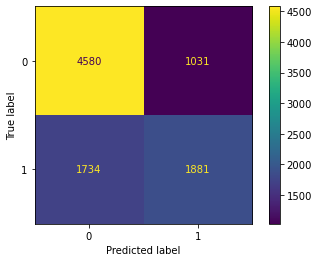

In [48]:
# plot the confusion matrix of the model
plot_confusion_matrix(reg, X_num_test, y_num_test)

**Interpretation:** There are 4580 correct predictions of the class 0 for churn; however, the false predictions of the class 0 is also significantly high which is up to 1031 reports. The number of the accurate class 1 values for churn is around 1881, while the false positive (inaccurate class 1 prediction in this case) is up to 1734 reports which is nearly the same as the true positive. Therefore, this model might not predict the class 1 for the churn precisely since the high false positive value, which might mislead the process of predicting the number of customers who might disconnect the service.

## Feature Selection:

* **Model of Churn Prediction based on Numerical Fields**

We will select the number of features from one to the total columns (fields) of the train set, then we calculate the accuracy score for each of the choices of features. As such, we could find the highest accuracy score to determine how many features could build the better model than the original one.

In [51]:
# list for containing all the accuracy score
test_acc_scores = []

print("The accuracy score of the model:")
for i in range(1, X_num_train.shape[1]+1):
    # build and fit the model
    lr = LogisticRegression()
    rfe = RFE(estimator = lr, n_features_to_select = i, step = 1)
    rfe.fit(X_num_train, y_num_train)
    # predict based on test set
    test_preds = rfe.predict(X_num_test)
    # calculate accuracy score and append to the list
    acc_score = accuracy_score(y_num_test, test_preds)
    test_acc_scores.append(acc_score)
    # print the number of features with the accuracy score
    print("- with selection of", i, "features: ", acc_score)

The accuracy score of the model:
- with selection of 1 features:  0.6375460654671581
- with selection of 2 features:  0.6546715803164969
- with selection of 3 features:  0.6553219163234337
- with selection of 4 features:  0.658031649685671
- with selection of 5 features:  0.6999783221331021
- with selection of 6 features:  0.6978105354433124
- with selection of 7 features:  0.6985692607847388
- with selection of 8 features:  0.6969434207673965
- with selection of 9 features:  0.6966182527639281
- with selection of 10 features:  0.7003034901365706


Text(0.5, 1.0, 'Accuracy at Each Number of Features')

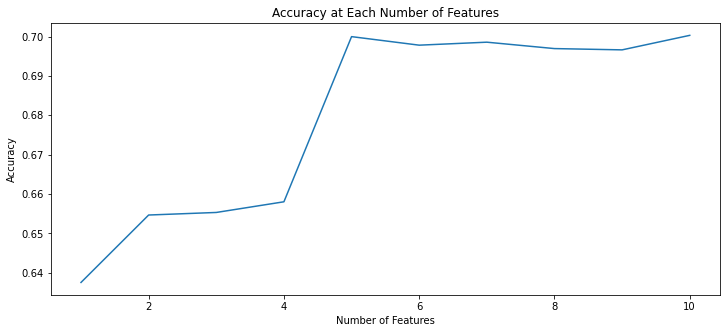

In [55]:
# Plotting the accuracy number
plt.figure(figsize=(12,5))
plt.plot(range(1, X_num_train.shape[1]+1), test_acc_scores)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy")
plt.title("Accuracy at Each Number of Features")

**Interpretation:** We could see the accuracy score of five-features model is nearly as high as (not much different from) the ten-features model (0.69998 compared to 0.70030). Therefore, we could build this "numerical only" model based on the five most important features instead of choosing all of the ten features to build.

In [57]:
# re-build the model by selecting five features
five_lr = LogisticRegression()
five_rfe = RFE(estimator = five_lr, n_features_to_select = 5, step = 1)
five_rfe.fit(X_num_train, y_num_train)

RFE(estimator=LogisticRegression(), n_features_to_select=5)

In [58]:
# check which five features have been selected
X_num_train.columns[five_rfe.support_]

Index(['ACCOUNT_TENURE', 'AGE', 'MONTHS_OF_CONTRACT_REMAINING',
       'LAST_FX_CONTRACT_DURATION', 'MONTHLY_SPEND'],
      dtype='object')

**Comment:** the five features could be selected to build a better model include monthly spend fee, account tenure in month, the age of customer, the remaining contract tenure in month, and the last fixed contract term.